<h1 style="color:blue">Dogs vs. Cats - CNN using MobileNetV2</h1>
<h4>Name: Burhan Hadi Butt, Taskeen Fatima</h4>
<h4>Enrollment: 03-134211-008, 03-134211-045</h4>
<h4>Class: BSCS - 7A</h4>

# Import Necessary Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import splitfolders
import shutil

import tensorflow as tf

from keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [2]:
# Set prerequisites

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

In [3]:
# Define the directories for dataset

input_data_dir = "dataset/dogs-vs-cats.zip"
extracted_input_data_dir = "dataset/dogs-vs-cats"

In [4]:
# Unzip the dataset

# Create the directory if it doesn't exist
os.makedirs(extracted_input_data_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(input_data_dir, 'r') as zip_ref:
    zip_ref.extractall(extracted_input_data_dir)

In [5]:
# Define the directories for train and test folders

train_data_dir = "dataset/dogs-vs-cats/train.zip"
test_data_dir = "dataset/dogs-vs-cats/test1.zip"
extracted_train_test_data_dir = "dataset/dogs-vs-cats"

In [6]:
# Uzip the train and test folders

# Create the directory if they doesn't exist
os.makedirs(extracted_train_test_data_dir, exist_ok=True)
os.makedirs(extracted_train_test_data_dir, exist_ok=True)

# Extract the contents of the zip files
with zipfile.ZipFile(train_data_dir, 'r') as zip_ref:
    zip_ref.extractall(extracted_train_test_data_dir)
with zipfile.ZipFile(test_data_dir, 'r') as zip_ref:
    zip_ref.extractall(extracted_train_test_data_dir)

In [7]:
# Load the test data

test_data = pd.read_csv('dataset/dogs-vs-cats/sampleSubmission.csv')

# Convert the columns values to strings
test_data['id'] = test_data['id'].astype(str)
test_data['label'] = test_data['label'].astype(str)

# Dataset Preprocessing

In [8]:
# Dataset defination

# Training and testing path
train_data_dir = "dataset/dogs-vs-cats/train"
test_data_dir = "dataset/dogs-vs-cats/test1"

# Create the train dataframe
filenames = os.listdir(train_data_dir)
class_names = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "labels": class_names})

nb_classes = len(class_names)

# Define image dimensions
img_height = 224
img_width = 224

# Define batch size
batch_size = 32

# Define dataset shape
input_shape = (img_height, img_width, 3)

In [9]:
# Number of samples in train and test set

# Get the number of samples in the train set
n_train = len(os.listdir(train_data_dir))

# Get the number of samples in the test set
n_test = len(os.listdir(test_data_dir))

# Print the number of samples in the train and test sets
print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))

Number of training examples: 25000
Number of testing examples: 12500


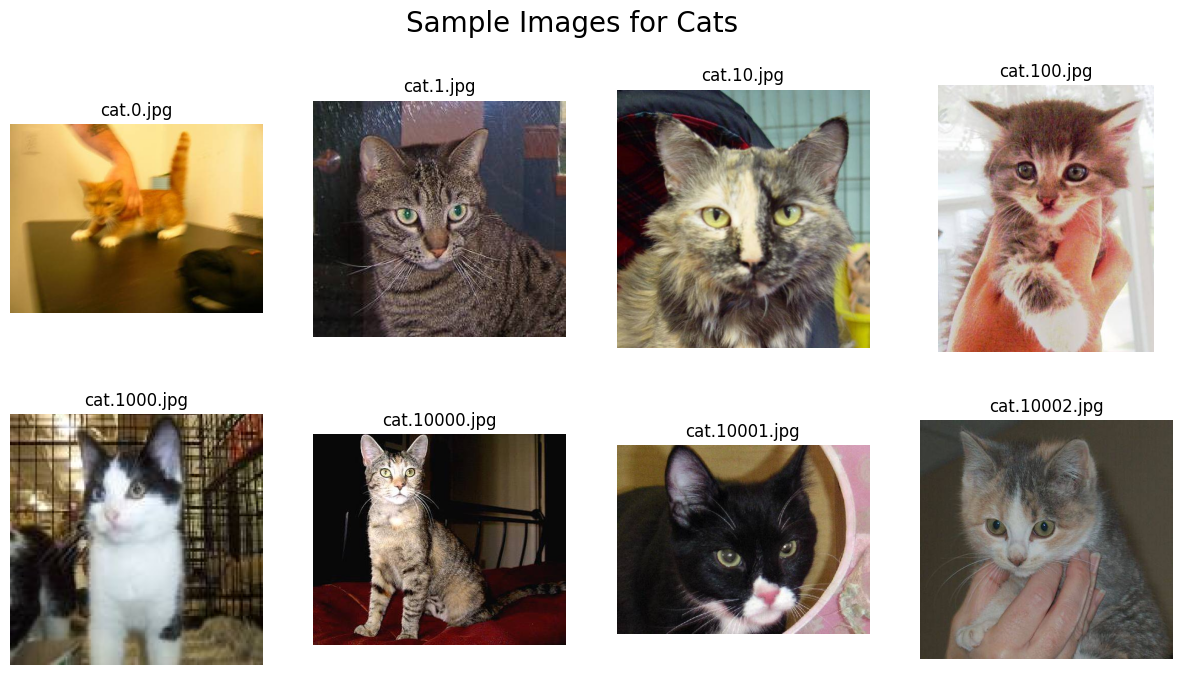

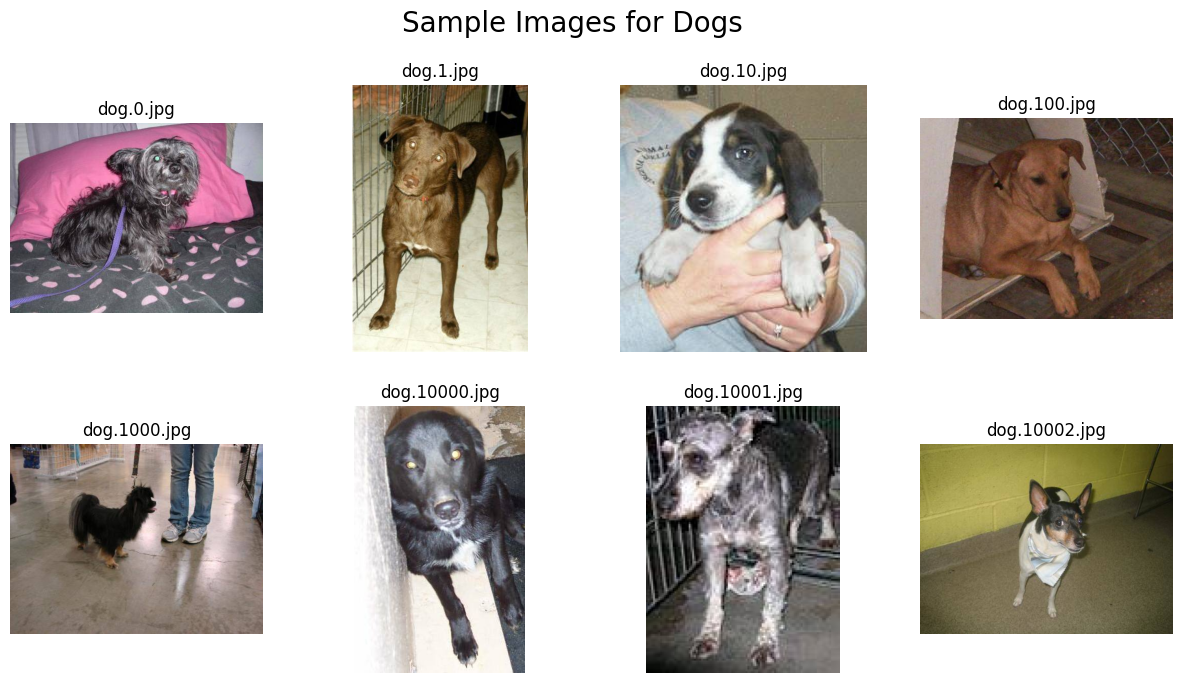

In [10]:
# Display sample images

# Get a list of filenames in the train directory
filenames = os.listdir(train_data_dir)

# Define the number of samples to display
num_samples = 8

# Define a counter for the number of displayed images
displayed_images = 0

# Plot the sample images for cats and dogs
plt.figure(figsize=(15, 15))
plt.suptitle("Sample Images for Cats", fontsize=20)
plt.subplots_adjust(top=0.93)

for filename in filenames:
    if "cat" in filename and displayed_images < num_samples:
        img_path = os.path.join(train_data_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Plot the image
            ax = plt.subplot(4, 4, displayed_images + 1)
            plt.imshow(img)
            plt.title(filename)
            plt.axis("off")
            
            displayed_images += 1

plt.show()

# Reset the counter
displayed_images = 0

# Reset the counter
displayed_images = 0

# Plot the sample images for dogs
plt.figure(figsize=(15, 15))
plt.suptitle("Sample Images for Dogs", fontsize=20)
plt.subplots_adjust(top=0.93)

for filename in filenames:
    if "dog" in filename and displayed_images < num_samples:
        img_path = os.path.join(train_data_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Plot the image
            ax = plt.subplot(4, 4, displayed_images + 1)
            plt.imshow(img)
            plt.title(filename)
            plt.axis("off")
            
            displayed_images += 1

plt.show()

In [11]:
# Apply Data Augmentation

# Split the data into training and testing sets with a ratio of 80% training and 20% testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define data generators for training and testing data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define data generators for training and testing data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_data_dir,
    x_col="filename",
    y_col="labels",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_data_dir,
    x_col="filename",
    y_col="labels",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

# Create a test generator for testing data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=train_data_dir,
    x_col="filename",
    y_col="labels",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

# Get the number of training and testing examples
n_train = len(train_generator.labels)
n_validation = len(validation_generator.labels)
n_test = len(test_generator.labels)

print("\nNumber of training examples:", n_train)
print("Number of validation examples:", n_validation)
print("Number of testing examples:", n_test)
print("\nEach image is of size: {}x{}x{}".format(img_height, img_width, 3))

Found 18000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.

Number of training examples: 18000
Number of validation examples: 2000
Number of testing examples: 5000

Each image is of size: 224x224x3


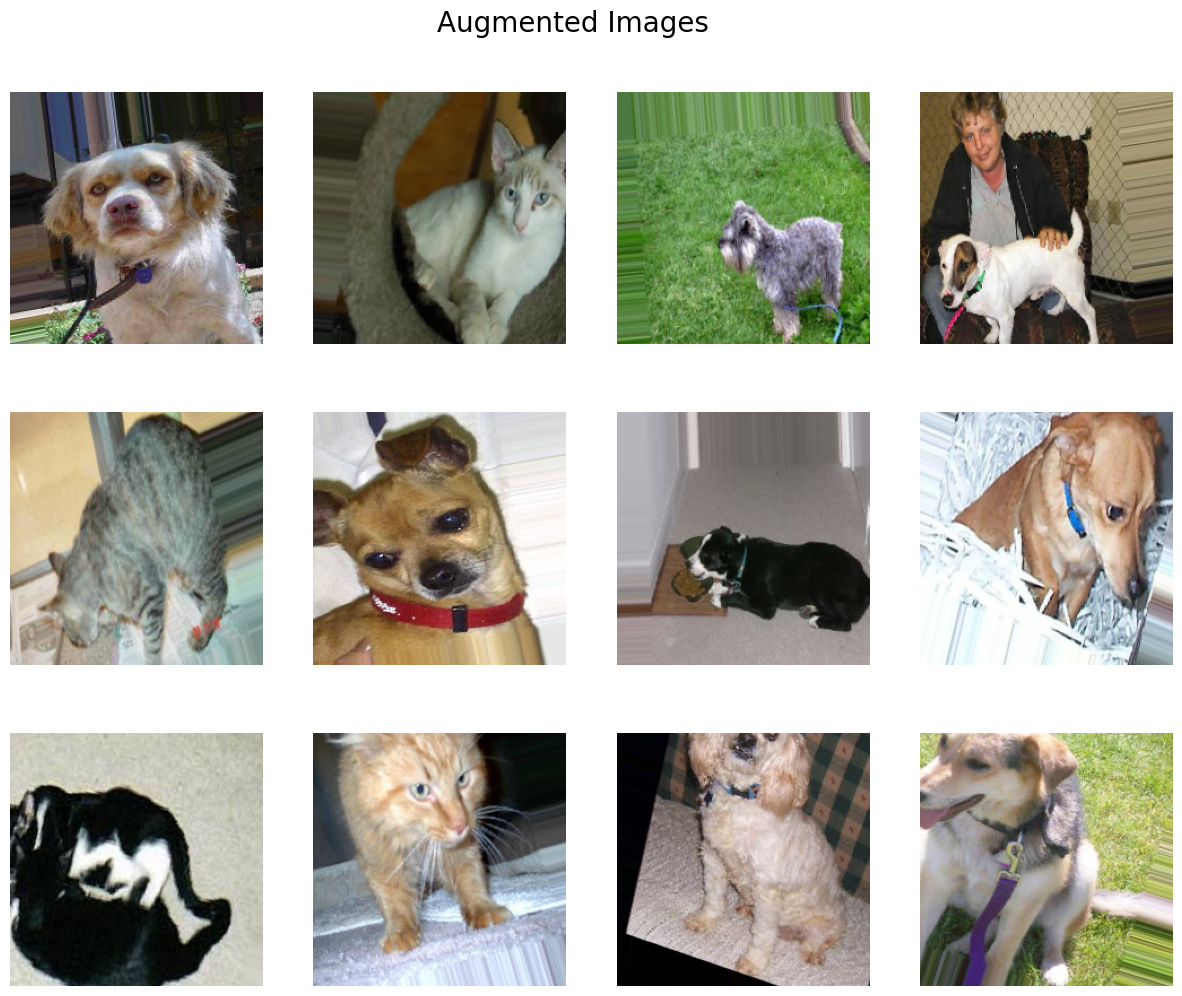

In [12]:
# Display augmented images

plt.figure(figsize=(15, 15))
plt.suptitle('Augmented Images', fontsize=20)
plt.subplots_adjust(top=0.93)
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    batch = next(train_generator)
    plt.imshow(batch[0][0])
    plt.axis("off")
plt.show()

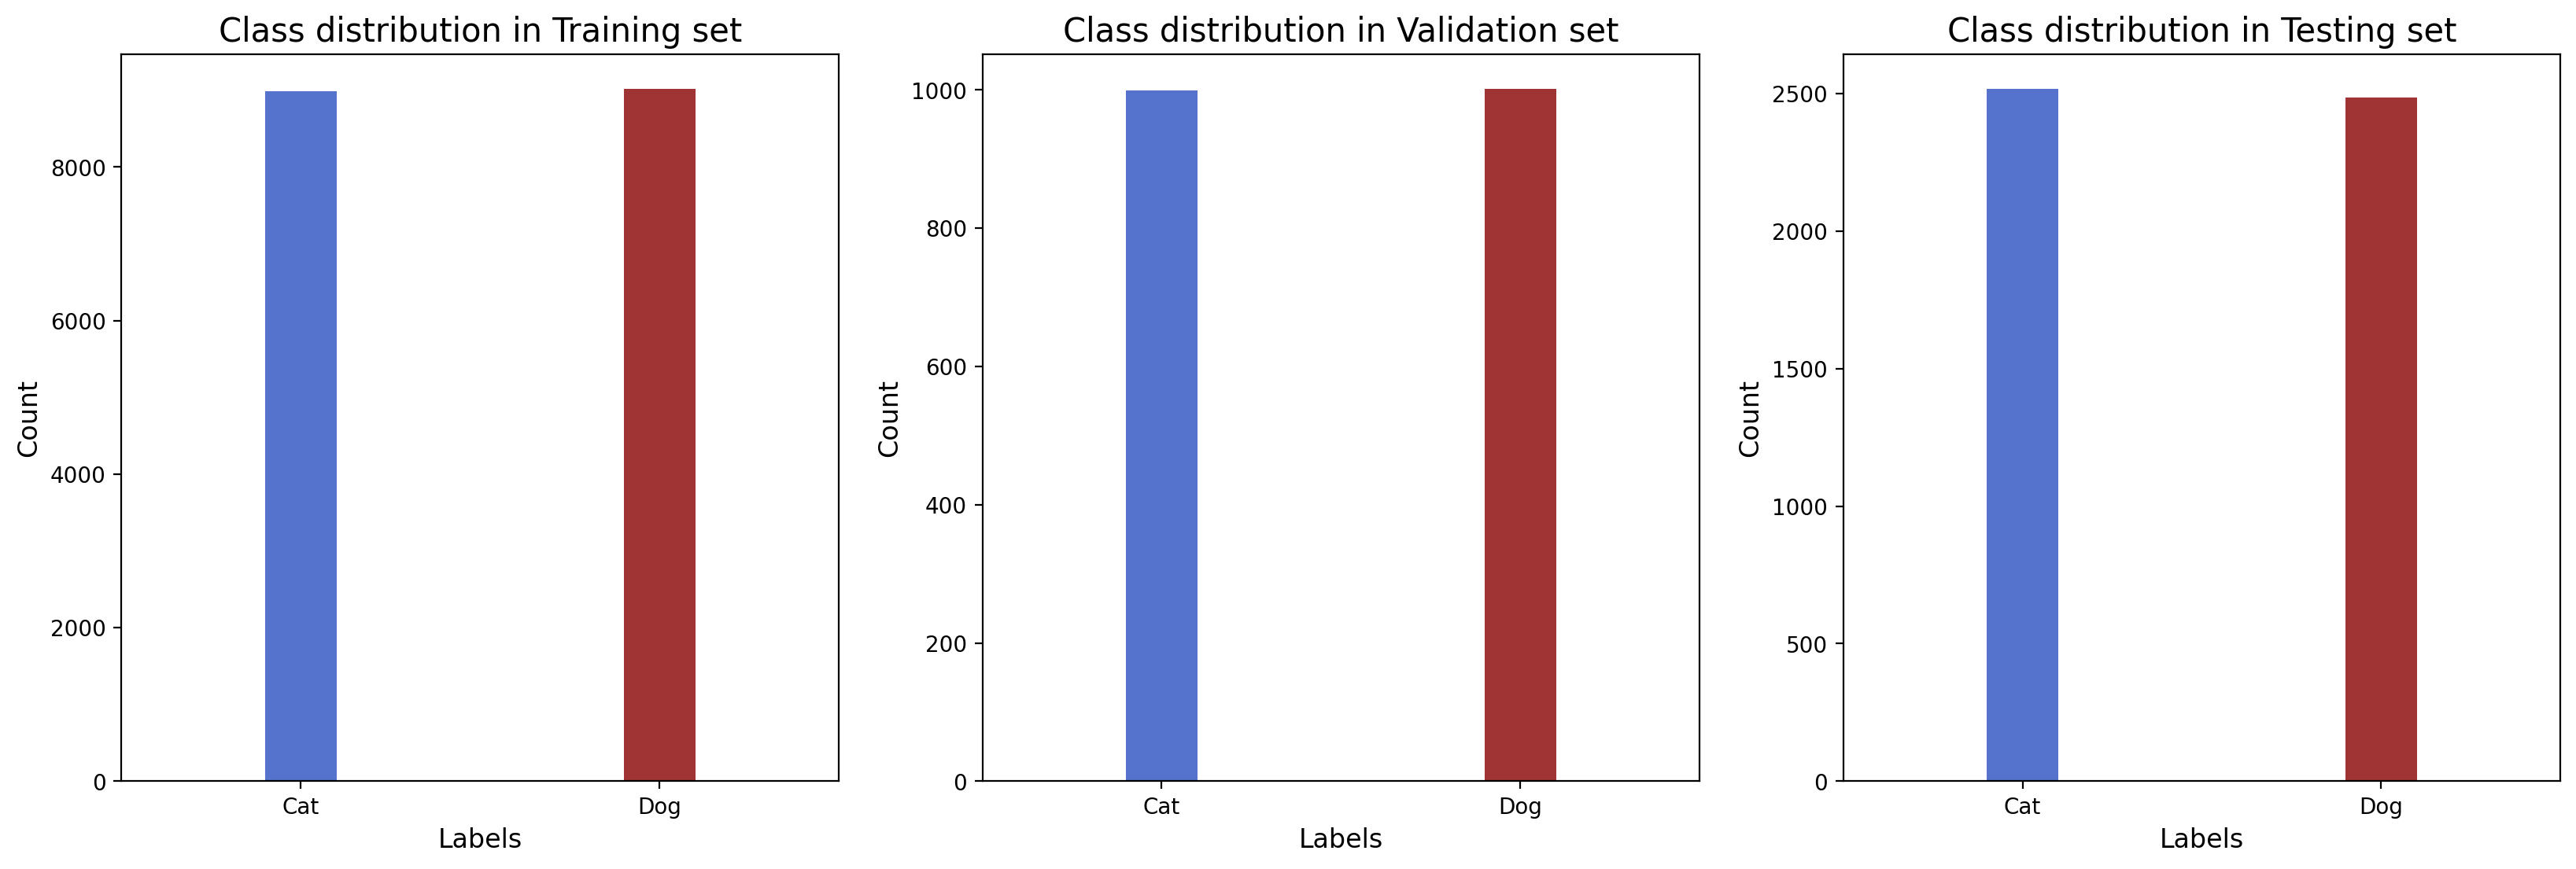

In [13]:
# Display the number of samples in each set

labels = ['Cat', 'Dog']

# Get the count of each label in the training, validation, and testing sets
label1, count1 = np.unique(train_generator.labels, return_counts=True)
label2, count2 = np.unique(validation_generator.labels, return_counts=True)
label3, count3 = np.unique(test_generator.labels, return_counts=True)

# Create dataframes for each set
uni1 = pd.DataFrame(data=count1, index=labels, columns=['Count1'])
uni2 = pd.DataFrame(data=count2, index=labels, columns=['Count2'])
uni3 = pd.DataFrame(data=count3, index=labels, columns=['Count3'])

# Plot the bar charts
plt.figure(figsize=(20, 6), dpi=200)

plt.subplot(131)
sns.barplot(data=uni1, x=uni1.index, y='Count1', hue=uni1.index, palette=['royalblue', 'firebrick'], width=0.2, legend=False).set_title('Class distribution in Training set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2, x=uni2.index, y='Count2', hue=uni2.index, palette=['royalblue', 'firebrick'], width=0.2, legend=False).set_title('Class distribution in Validation set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(133)
sns.barplot(data=uni3, x=uni3.index, y='Count3', hue=uni3.index, palette=['royalblue', 'firebrick'], width=0.2, legend=False).set_title('Class distribution in Testing set', fontsize=15)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

# MobileNetV2 Trained Model

In [14]:
# Load pre-trained MobileNetV2 model

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Print base model summary
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [15]:
# Freeze the convolutional base of the model

base_model.trainable = False

# Version 1: Adam optimizer with Early Stopping

In [16]:
# Define hyperparameters

input_shape = (img_height, img_width, 3)
learning_rate = 0.001
loss = 'binary_crossentropy'
metrics=['accuracy']
epochs = 30

In [17]:
# Construct the model

model = Sequential([base_model, Flatten(), Dense(256, activation='relu'), Dense(1, activation='sigmoid')])

In [18]:
# Compile the model

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18,314,817
Trainable params: 16,056,833
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
# Define early stopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
# Train the model

model_history_v1 = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

# Print the trainging accuracy
training_accuracy = model_history_v1.history['accuracy'][-1]
print("\nTraining Accuracy:", round(training_accuracy, 2))

Epoch 1/30
563/563 [==============================] - 424s 746ms/step - loss: 0.6015 - accuracy: 0.9528 - val_loss: 0.1054 - val_accuracy: 0.9670
Epoch 2/30
563/563 [==============================] - 412s 731ms/step - loss: 0.0861 - accuracy: 0.9661 - val_loss: 0.0872 - val_accuracy: 0.9645
Epoch 3/30
563/563 [==============================] - 405s 720ms/step - loss: 0.0734 - accuracy: 0.9713 - val_loss: 0.0700 - val_accuracy: 0.9695
Epoch 4/30
563/563 [==============================] - 417s 740ms/step - loss: 0.0646 - accuracy: 0.9754 - val_loss: 0.0681 - val_accuracy: 0.9700
Epoch 5/30
563/563 [==============================] - 406s 721ms/step - loss: 0.0663 - accuracy: 0.9740 - val_loss: 0.0595 - val_accuracy: 0.9730
Epoch 6/30
563/563 [==============================] - 409s 727ms/step - loss: 0.0631 - accuracy: 0.9753 - val_loss: 0.0682 - val_accuracy: 0.9715
Epoch 7/30
563/563 [==============================] - 409s 727ms/step - loss: 0.0603 - accuracy: 0.9761 - val_loss: 0.0774 -

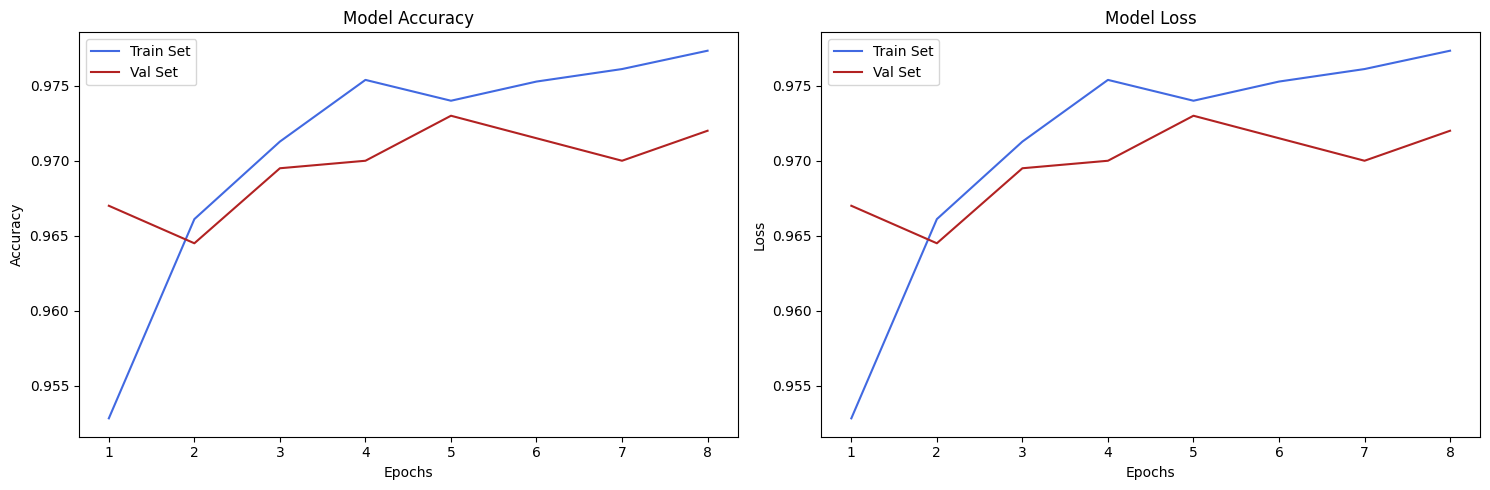

In [21]:
# Accuracy-loss curves for training and validation data

acc = model_history_v1.history['accuracy']
val_acc = model_history_v1.history['val_accuracy']
loss = model_history_v1.history['loss']
val_loss = model_history_v1.history['val_loss']
epochs_range = range(1, len(model_history_v1.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set',  color='royalblue')
plt.plot(epochs_range, val_acc, label='Val Set', color='firebrick')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Train Set',  color='royalblue')
plt.plot(epochs_range, val_acc, label='Val Set', color='firebrick')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [22]:
# Save the model

model.save("model/MobileNetV2_with_Adam_Optimizer.keras")

# Model Evaluation

In [23]:
# Make predictions on test data

predictions = model.predict(test_generator)
predicted_labels = np.round(predictions).flatten()
print(predicted_labels)

# Get the true labels and class names from test data
true_labels = test_generator.classes
class_names = test_generator.class_indices.keys()

157/157 [==============================] - 74s 468ms/step
[0. 1. 0. ... 0. 1. 0.]


In [24]:
# Accuracy Score

accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy Score:", np.round(accuracy, 2))


Accuracy Score: 0.98


In [25]:
# Classification Report

print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits = 4))


Classification Report:

              precision    recall  f1-score   support

         cat     0.9906    0.9654    0.9778      2515
         dog     0.9659    0.9907    0.9781      2485

    accuracy                         0.9780      5000
   macro avg     0.9782    0.9781    0.9780      5000
weighted avg     0.9783    0.9780    0.9780      5000



In [26]:
# Define the confusion matrix

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

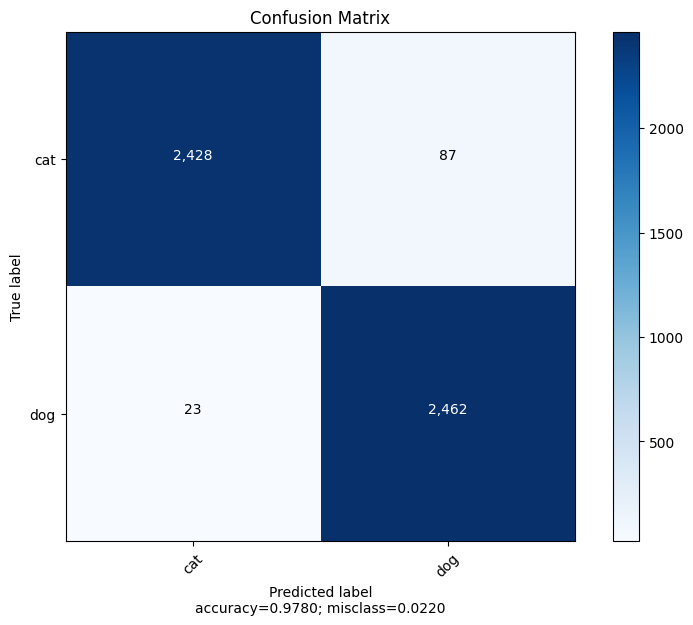

In [27]:
# Confusion Matrix

confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, target_names=class_names, normalize=False)

# Version 2: RMSProp Optimizer with Learning Rate Decay

In [28]:
# Define hyperparameters

input_shape = (img_height, img_width, 3)
learning_rate = 0.001
loss = 'binary_crossentropy'
metrics=['accuracy']
epochs = 30

In [29]:
# Construct the model

model = Sequential([base_model, Flatten(), Dense(256, activation='relu'), Dense(1, activation='sigmoid')])

In [30]:
# learning Rate Decay

# Define learning rate decay scheduler
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

In [31]:
# Compile the model

optimizer = RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16056576  
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18,314,817
Trainable params: 16,056,833
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
# Define learning rate decay callback

lr_decay = LearningRateScheduler(lr_scheduler)

In [33]:
# Train the model

model_history_v2 = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, batch_size=batch_size, callbacks=[lr_decay], verbose=1)

# Print the training accuracy
training_accuracy = model_history_v2.history['accuracy'][-1]
print("\nTraining Accuracy:", round(training_accuracy, 2))

Epoch 1/30
563/563 [==============================] - 441s 777ms/step - loss: 0.7283 - accuracy: 0.9488 - val_loss: 0.1663 - val_accuracy: 0.9665 - lr: 9.0484e-04
Epoch 2/30
563/563 [==============================] - 439s 780ms/step - loss: 0.1885 - accuracy: 0.9645 - val_loss: 0.1610 - val_accuracy: 0.9680 - lr: 8.1873e-04
Epoch 3/30
563/563 [==============================] - 435s 772ms/step - loss: 0.1536 - accuracy: 0.9667 - val_loss: 0.1307 - val_accuracy: 0.9700 - lr: 7.4082e-04
Epoch 4/30
563/563 [==============================] - 434s 771ms/step - loss: 0.1343 - accuracy: 0.9705 - val_loss: 0.2689 - val_accuracy: 0.9555 - lr: 6.7032e-04
Epoch 5/30
563/563 [==============================] - 435s 772ms/step - loss: 0.1188 - accuracy: 0.9727 - val_loss: 0.1305 - val_accuracy: 0.9745 - lr: 6.0653e-04
Epoch 6/30
563/563 [==============================] - 436s 774ms/step - loss: 0.1212 - accuracy: 0.9729 - val_loss: 0.1283 - val_accuracy: 0.9730 - lr: 5.4881e-04
Epoch 7/30
563/563 [==

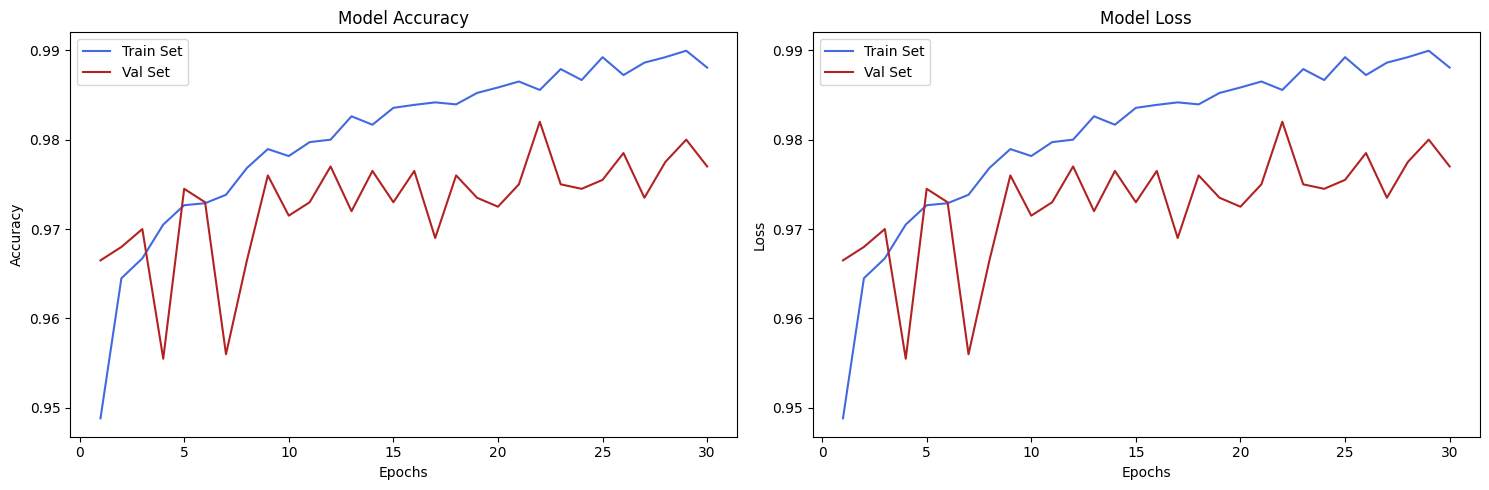

In [34]:
# Accuracy-loss curves for training and validation data

acc = model_history_v2.history['accuracy']
val_acc = model_history_v2.history['val_accuracy']
loss = model_history_v2.history['loss']
val_loss = model_history_v2.history['val_loss']
epochs_range = range(1, len(model_history_v2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set',  color='royalblue')
plt.plot(epochs_range, val_acc, label='Val Set', color='firebrick')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Train Set',  color='royalblue')
plt.plot(epochs_range, val_acc, label='Val Set', color='firebrick')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [35]:
# Save the model

model.save("model/MobileNetV2_with_RMSProp_Optimizer.keras")

# Model Evaluation

In [36]:
# Make predictions on test data

predictions = model.predict(test_generator)
predicted_labels = np.round(predictions).flatten()
print(predicted_labels)

# Get the true labels and class names from test data
true_labels = test_generator.classes
class_names = test_generator.class_indices.keys()

157/157 [==============================] - 68s 425ms/step
[0. 1. 0. ... 0. 1. 0.]


In [37]:
# Accuracy Score

accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy Score:", np.round(accuracy, 2))


Accuracy Score: 0.98


In [38]:
# Classification Report

print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits = 4))


Classification Report:

              precision    recall  f1-score   support

         cat     0.9825    0.9821    0.9823      2515
         dog     0.9819    0.9823    0.9821      2485

    accuracy                         0.9822      5000
   macro avg     0.9822    0.9822    0.9822      5000
weighted avg     0.9822    0.9822    0.9822      5000



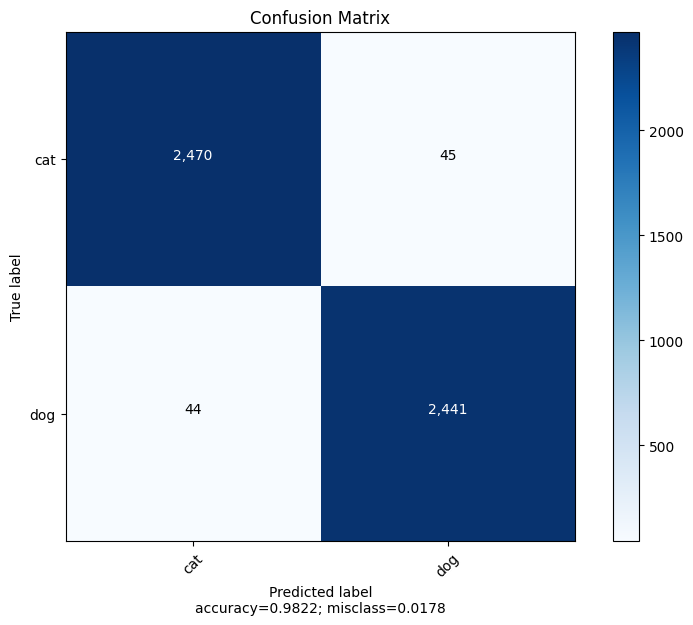

In [39]:
# Confusion Matrix

confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, target_names=class_names, normalize=False)

# Version 3: SGD Optimizer with Momentum and Learning Rate Decay

In [40]:
# Define hyperparameters

input_shape = (img_height, img_width, 3)
learning_rate = 0.001
loss = 'binary_crossentropy'
metrics=['accuracy']
epochs = 30

In [41]:
# Construct the model

model = Sequential([base_model, Flatten(), Dense(256, activation='relu'), Dense(1, activation='sigmoid')])

In [42]:
# Compile the model

optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               16056576  
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18,314,817
Trainable params: 16,056,833
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
# Define learning rate decay callback

lr_decay = LearningRateScheduler(lr_scheduler)

In [44]:
# Train the model

model_history_v3 = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, batch_size=batch_size, callbacks=[lr_decay], verbose=1)

# Print the training accuracy
training_accuracy = model_history_v3.history['accuracy'][-1]
print("\nTraining Accuracy:", round(training_accuracy, 2))

Epoch 1/30
563/563 [==============================] - 394s 693ms/step - loss: 0.0991 - accuracy: 0.9618 - val_loss: 0.0793 - val_accuracy: 0.9675 - lr: 9.0484e-04
Epoch 2/30
563/563 [==============================] - 392s 697ms/step - loss: 0.0697 - accuracy: 0.9721 - val_loss: 0.0654 - val_accuracy: 0.9720 - lr: 8.1873e-04
Epoch 3/30
563/563 [==============================] - 372s 661ms/step - loss: 0.0593 - accuracy: 0.9759 - val_loss: 0.0676 - val_accuracy: 0.9740 - lr: 7.4082e-04
Epoch 4/30
563/563 [==============================] - 369s 656ms/step - loss: 0.0550 - accuracy: 0.9786 - val_loss: 0.0624 - val_accuracy: 0.9755 - lr: 6.7032e-04
Epoch 5/30
563/563 [==============================] - 370s 658ms/step - loss: 0.0508 - accuracy: 0.9805 - val_loss: 0.0692 - val_accuracy: 0.9740 - lr: 6.0653e-04
Epoch 6/30
563/563 [==============================] - 387s 687ms/step - loss: 0.0510 - accuracy: 0.9806 - val_loss: 0.0638 - val_accuracy: 0.9735 - lr: 5.4881e-04
Epoch 7/30
563/563 [==

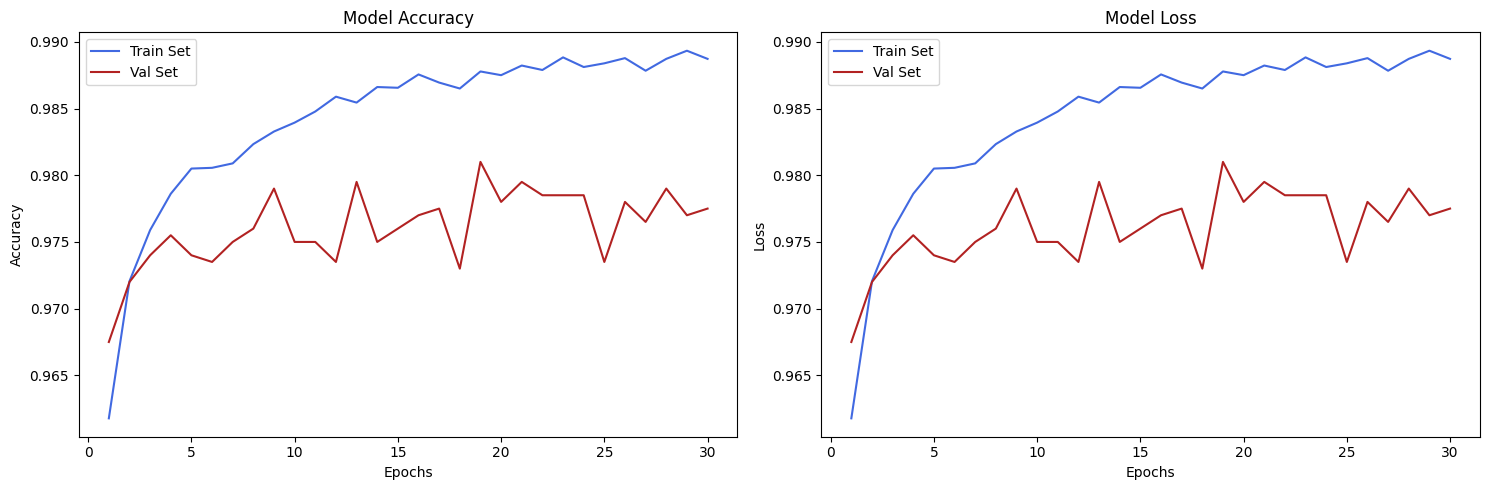

In [45]:
# Accuracy-loss curves for training and validation data

acc = model_history_v3.history['accuracy']
val_acc = model_history_v3.history['val_accuracy']
loss = model_history_v3.history['loss']
val_loss = model_history_v3.history['val_loss']
epochs_range = range(1, len(model_history_v3.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set',  color='royalblue')
plt.plot(epochs_range, val_acc, label='Val Set', color='firebrick')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Train Set',  color='royalblue')
plt.plot(epochs_range, val_acc, label='Val Set', color='firebrick')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [46]:
# Save the model

model.save("model/MobileNetV2-V3_with_SGD_Optimizer.keras")

# Model Evaluation

In [47]:
# Make predictions on test data

predictions = model.predict(test_generator)
predicted_labels = np.round(predictions).flatten()
print(predicted_labels)

# Get the true labels and class names from test data
true_labels = test_generator.classes
class_names = test_generator.class_indices.keys()

157/157 [==============================] - 74s 462ms/step
[0. 1. 0. ... 0. 1. 0.]


In [48]:
# Accuracy Score

accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy Score:", np.round(accuracy, 2))


Accuracy Score: 0.98


In [49]:
# Classification Report

print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits = 4))


Classification Report:

              precision    recall  f1-score   support

         cat     0.9896    0.9797    0.9846      2515
         dog     0.9797    0.9895    0.9846      2485

    accuracy                         0.9846      5000
   macro avg     0.9846    0.9846    0.9846      5000
weighted avg     0.9846    0.9846    0.9846      5000



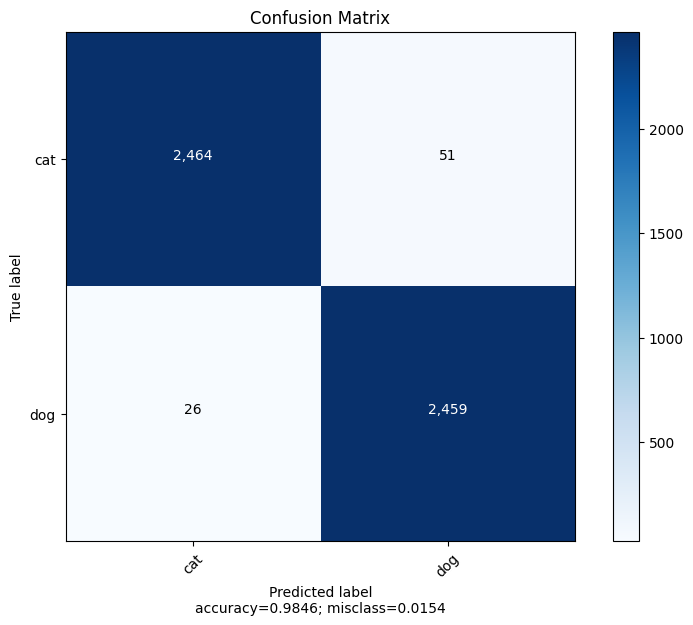

In [50]:
# Confusion Matrix

confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, target_names=class_names, normalize=False)

# Application Phase

In [51]:
# Load the best model

loaded_model = load_model("model/MobileNetV2_with_Adam_Optimizer.keras")

In [52]:
# Run the model on unseen data from user

def predict_and_display_images(model, test_data_dir):
    test_files = os.listdir(test_data_dir)[:12]

    # Prepare subplots
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()

    for i, filename in enumerate(test_files):
        # Load and preprocess image
        img_path = os.path.join(test_data_dir, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        predicted_class = "dog" if prediction > 0.5 else "cat"

        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {predicted_class}", color='red')
        axes[i].axis('off')
        
        axes[i].set_ylim(img.size[1] + 10, -5)
        
    plt.tight_layout()
    plt.show()

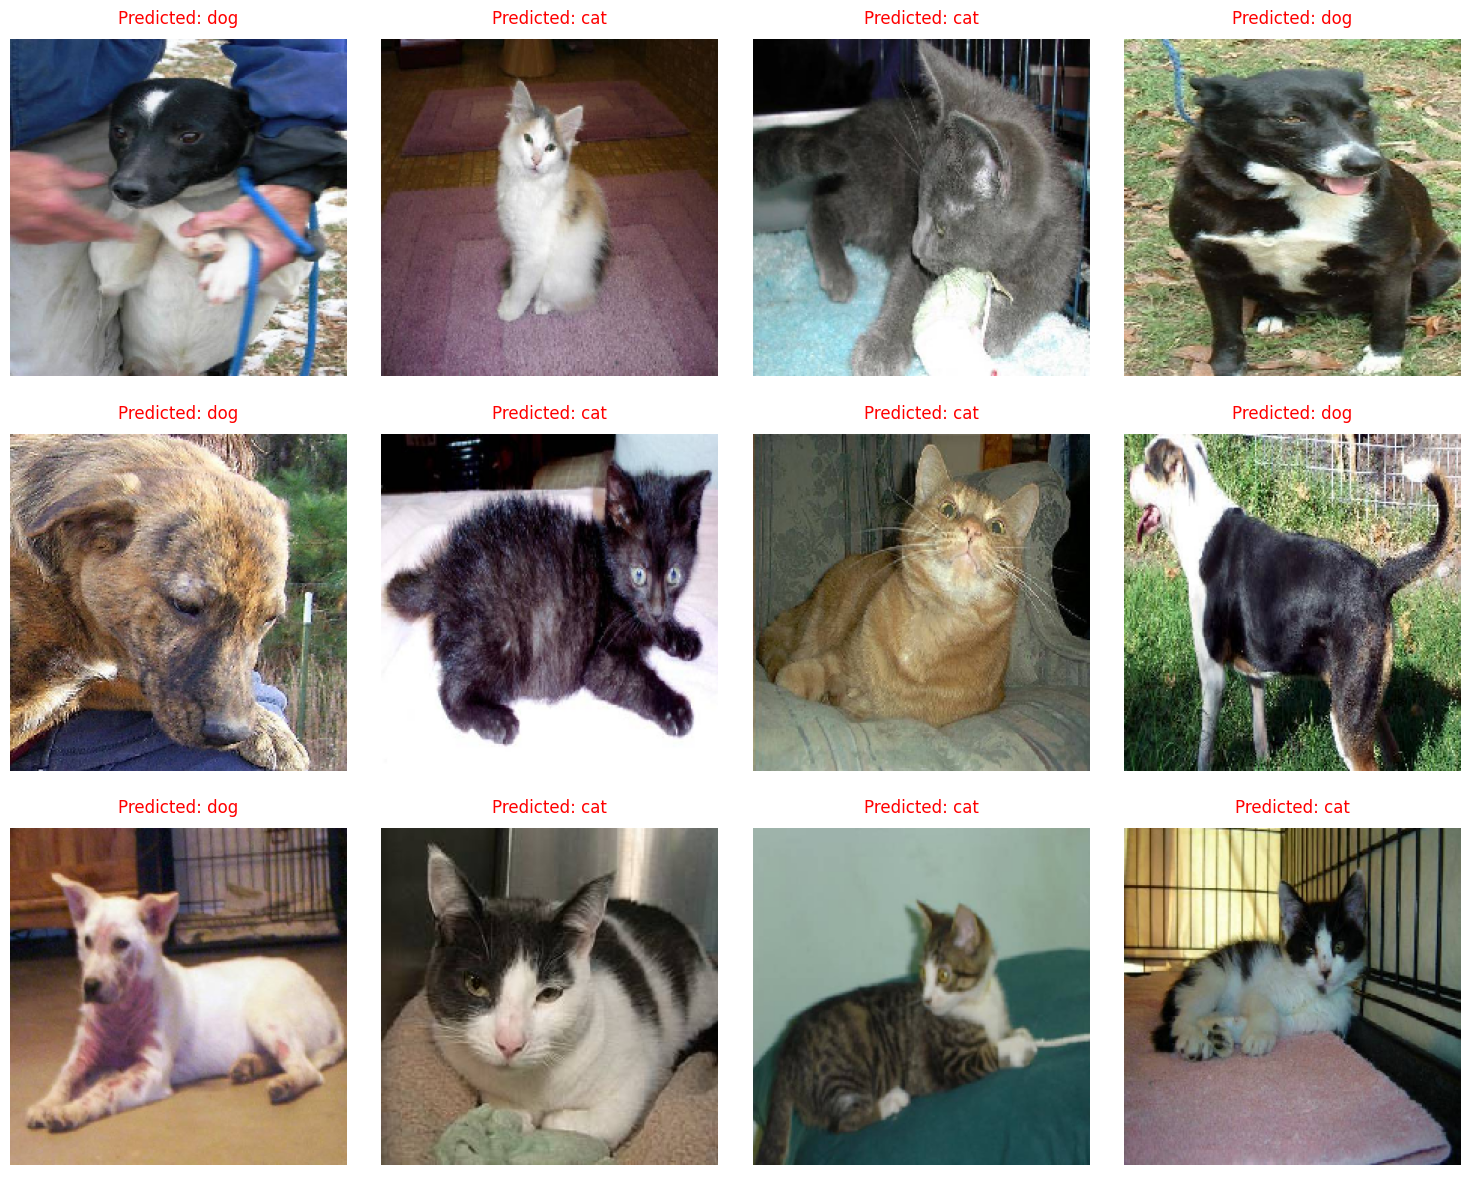

In [53]:
# Usage

predict_and_display_images(model, test_data_dir)